# Testing Notebook


Random online python phenology functions that might help:

- https://gist.github.com/YanCheng-go/d4e17831f294199443d0f7682558e608

- https://github.com/JavierLopatin/PhenoPY



In [ ]:
# !pip install richdem
# !pip install xarray --upgrade

In [8]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
import hdstats
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
from matplotlib.patches import Patch
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from deafrica_temporal_statistics import xr_phenology, temporal_statistics, fast_completion, smooth
from datacube.utils.geometry import assign_crs
from deafrica_dask import create_local_dask_cluster

import warnings
warnings.filterwarnings("ignore", "Mean of empty slice")
warnings.simplefilter("ignore", FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# create_local_dask_cluster()

### Connect to the datacube

In [4]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters


In [2]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'
products = 'ls8_usgs_sr_scene', 'usgs_ls8c_level2_2' 
# Define area of interest
lat = 13.9437 #22.8056 #22.817 #-34.288 
lon = -16.5488# 28.5191 #28.518 #20.012 
lon_buffer = 0.05
lat_buffer = 0.05

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2017')

## View the selected location

In [ ]:
# display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [6]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red', 'nir', 'green', 'blue', 'swir1', 'swir2'],
    'resolution': (-30,30),
    'output_crs': 'epsg:6933'
}

# Load available data from Landsat 8
ds_c1 = load_ard(dc=dc,
              products=[products[0]],
              min_gooddata = 0.25,
              **query
              )

# Load available data from Landsat 8
ds_c2 = load_ard(dc=dc,
              products=[products[1]],
              min_gooddata = 0.25,
              **query
              )

# print(ds)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 13 out of 48 time steps with at least 25.0% good quality pixels
Applying pixel quality/cloud mask
Loading 13 time steps
Using pixel quality parameters for USGS Collection 2
Finding datasets
    usgs_ls8c_level2_2
Counting good quality pixels for each time step
Filtering to 13 out of 49 time steps with at least 25.0% good quality pixels
Applying pixel quality/cloud mask
Loading 13 time steps


NameError: name 'ds' is not defined

In [ ]:
# ndvi = (ds.nir - ds.red)/(ds.nir + ds.red)

In [ ]:
# ndvi.mean(['x','y']).plot.line('b--', figsize=(11,5))
# plt.ylim(0,0.9)
# plt.title('NDVI '+product)

In [ ]:
# idx = 5
# rgb(ds, index=idx)
# plt.title(product + " "+ str(ds.isel(time=idx).time.values)[0:10])

In [ ]:
# ndvi.isel(time=idx).plot(size=6, vmin=0, vmax=0.9, cmap='YlGn')
# plt.title(product +' NDVI '+ str(ds.isel(time=idx).time.values)[0:10])

In [ ]:
# ds = ds / 10000
# ds.red.mean(['x','y']).plot.line('b--', figsize=(11,5))
# plt.ylim(0,1)
# plt.title(product +' red '+ str(ds.isel(time=idx).time.values)[0:10])

In [ ]:
# ds.nir.mean(['x','y']).plot.line('b--', figsize=(11,5))
# plt.ylim(0,1)
# plt.title(product +' nir '+ str(ds.isel(time=idx).time.values)[0:10])


In [ ]:
ds.mean(['x','y']).min()

In [24]:
ndvi_c1 = (ds_c1.nir - ds_c1.red)/(ds_c1.nir + ds_c1.red)
ndvi_c2 = (ds_c2.nir - ds_c2.red)/(ds_c2.nir + ds_c2.red)

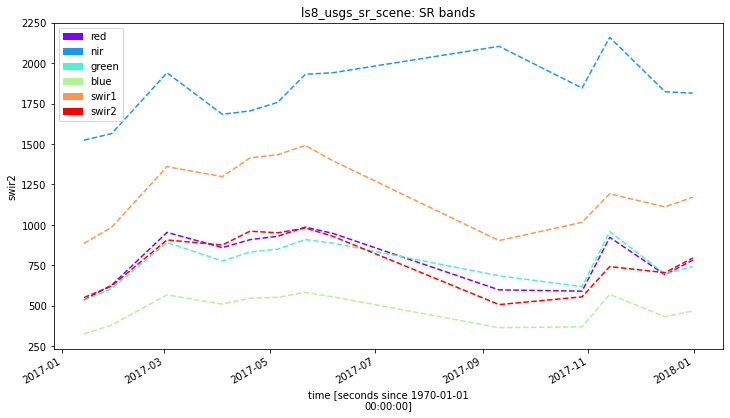

In [10]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

color=iter(cm.rainbow(np.linspace(0,1,6)))
x=[]
y=[]
for i,c in zip(ds_c1.data_vars, range(0,6)):
    c=next(color)
    x.append(c)
    y.append(i)
    ds_c1[i].mean(['x','y']).plot.line('b--', ax=axes, c=c)
#     plt.ylim(0,0.4)
    plt.title(products[0] + ': SR bands')
    
axes.legend([Patch(facecolor=x[0]), Patch(facecolor=x[1]), Patch(facecolor=x[2]), Patch(facecolor=x[3]), Patch(facecolor=x[4]),Patch(facecolor=x[5])],
            [y[0],y[1],y[2],y[3],y[4],y[5]]);



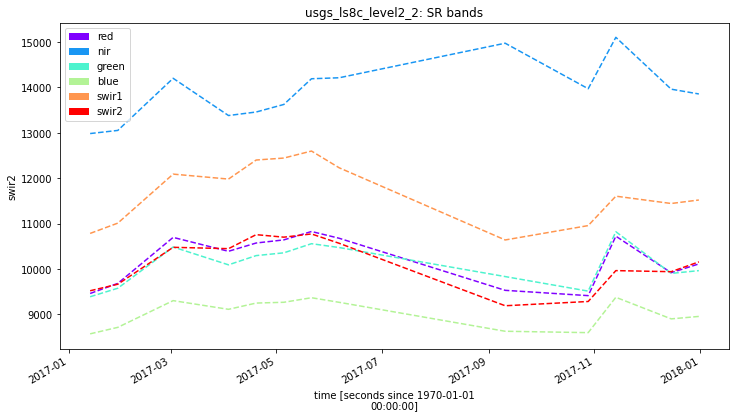

In [11]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

color=iter(cm.rainbow(np.linspace(0,1,6)))
x=[]
y=[]
for i,c in zip(ds_c2.data_vars, range(0,6)):
    c=next(color)
    x.append(c)
    y.append(i)
    ds_c2[i].mean(['x','y']).plot.line('b--', ax=axes, c=c)
#     plt.ylim(0,0.4)
    plt.title(products[1] + ': SR bands')
    
axes.legend([Patch(facecolor=x[0]), Patch(facecolor=x[1]), Patch(facecolor=x[2]), Patch(facecolor=x[3]), Patch(facecolor=x[4]),Patch(facecolor=x[5])],
            [y[0],y[1],y[2],y[3],y[4],y[5]])


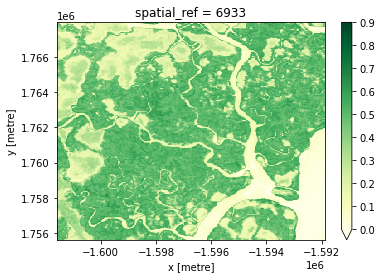

In [29]:
ndvi_c1.mean('time').plot(cmap='YlGn', vmin=0,vmax=0.9)

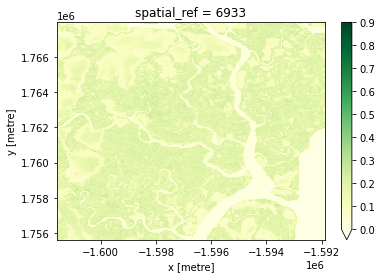

In [30]:
ndvi_c2.mean('time').plot(cmap='YlGn', vmin=0,vmax=0.9)

In [31]:
ds_c1_raw = dc.load(product=products[0], **query)
ds_c2_raw = dc.load(product=products[1], **query)

In [36]:
ds_c2_raw

<xarray.Dataset>
Dimensions:      (time: 49, x: 323, y: 413)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-13T11:27:38.261853 ... 2017-12-31T11:28:01.498130
  * y            (y) float64 1.768e+06 1.768e+06 ... 1.756e+06 1.756e+06
  * x            (x) float64 -1.602e+06 -1.602e+06 ... -1.592e+06 -1.592e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 14297 18343 16712 17858 19254 ... 0 0 0 0 0
    nir          (time, y, x) uint16 15186 21740 20709 21604 21985 ... 0 0 0 0 0
    green        (time, y, x) uint16 12903 15763 14555 15685 16665 ... 0 0 0 0 0
    blue         (time, y, x) uint16 10557 13485 11541 12616 14004 ... 0 0 0 0 0
    swir1        (time, y, x) uint16 13707 22337 22010 24015 22939 ... 0 0 0 0 0
    swir2        (time, y, x) uint16 11618 19676 19425 21820 21043 ... 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [37]:
ds_c1_raw

<xarray.Dataset>
Dimensions:      (time: 48, x: 323, y: 413)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-13T11:27:38.261853 ... 2017-12-31T11:28:01.498130
  * y            (y) float64 1.768e+06 1.768e+06 ... 1.756e+06 1.756e+06
  * x            (x) float64 -1.602e+06 -1.602e+06 ... -1.592e+06 -1.592e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) int16 1235 2736 2693 2828 ... -9999 -9999 -9999
    nir          (time, y, x) int16 1248 3201 3817 3856 ... -9999 -9999 -9999
    green        (time, y, x) int16 1044 2193 1972 2221 ... -9999 -9999 -9999
    blue         (time, y, x) int16 648 1434 1373 1342 ... -9999 -9999 -9999
    swir1        (time, y, x) int16 793 3296 4009 4333 ... -9999 -9999 -9999
    swir2        (time, y, x) int16 503 2546 3163 3764 ... -9999 -9999 -9999
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [33]:
ndvi_c1_raw = (ds_c1_raw.nir - ds_c1_raw.red)/(ds_c1_raw.nir + ds_c1_raw.red)
ndvi_c2_raw = (ds_c2_raw.nir - ds_c2_raw.red)/(ds_c2_raw.nir + ds_c2_raw.red)

In [39]:
ndvi_c1_raw

<xarray.DataArray (time: 48, y: 413, x: 323)>
array([[[ 0.0052356 ,  0.07832239,  0.17265745, ...,  0.6308113 ,
          0.62746943,  0.69268694],
        [-0.21762786, -0.01092582,  0.06925065, ...,  0.54549926,
          0.53968254,  0.57553957],
        [-0.31057564, -0.37519623,  0.51061678, ...,  0.54549926,
          0.53968254,  0.57553957],
        ...,
        [ 0.58923347,  0.56094527,  0.60412148, ..., -0.13679245,
         -0.150358  , -0.14423077],
        [ 0.59839357,  0.60113314,  0.62852745, ..., -0.14754098,
         -0.14832536, -0.15402299],
        [ 0.57913247,  0.60157127,  0.60497835, ..., -0.14754098,
         -0.13809524, -0.17241379]],

       [[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        ...,
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[ 0.008285  ,  0.11156793,  0.17517483, ...,  0.58378378,
          0.5881295 ,  0.65235008],
        [-0.21698662, -0.0306425 ,  0.12547119, ...,  0.52120641,
          0.49683081,  0.52434649],
        [-0.25398936, -0.24796447,  0.43099788, ...,  0.52120641,
          0.49683081,  0.52434649],
        ...,
        [ 0.55120947,  0.52858684,  0.55232849, ..., -0.06788991,
         -0.06077348, -0.05360444],
        [ 0.56165751,  0.56973294,  0.58425926, ..., -0.05128205,
         -0.05128205, -0.06739526],
        [ 0.55118925,  0.56163022,  0.56412729, ..., -0.05128205,
         -0.04936015, -0.07468124]],

       ...,

       [[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        ...,
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[ 0.02642559,  0.09699346,  0.18608964, ...,  0.56826138,
          0.54455446,  0.61348315],
        [-0.0099963 ,  0.06925566,  0.11090261, ...,  0.50451189,
          0.47341557,  0.52753258],
        [ 0.03440539, -0.11534702,  0.41996234, ...,  0.50451189,
          0.47341557,  0.52753258],
        ...,
        [ 0.53762912,  0.51329243,  0.55079217, ..., -0.02013423,
         -0.01333333, -0.015625  ],
        [ 0.55362319,  0.53957529,  0.5802255 , ..., -0.00664452,
         -0.01302932, -0.03367496],
        [ 0.54211036,  0.55182073,  0.56185335, ..., -0.00664452,
          0.        , -0.01729107]],

       [[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        ...,
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]]])
Coordinates:
  * time         (time) datetime64[ns] 2017-01-13T11:27:38.261853 ... 2017-12-31T11:28:01.498130
  * y            (y) float64 1.768e+06 1.768e+06 ... 1.756e+06 1.756e

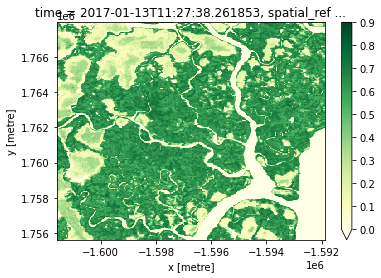

In [41]:
ndvi_c1_raw.isel(time=0).plot(cmap='YlGn', vmin=0,vmax=0.9)

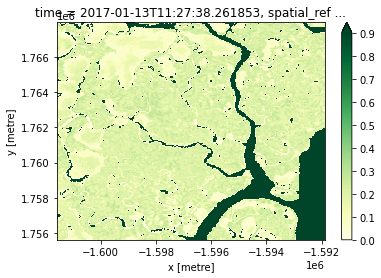

In [42]:
ndvi_c2_raw.isel(time=0).plot(cmap='YlGn', vmin=0,vmax=0.9)

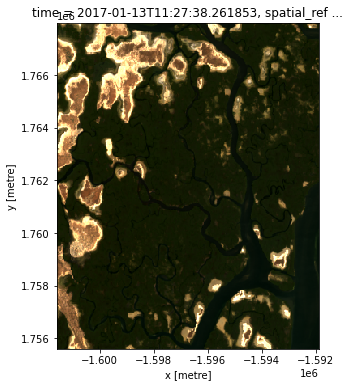

In [44]:
rgb(ds_c1_raw, index=0)

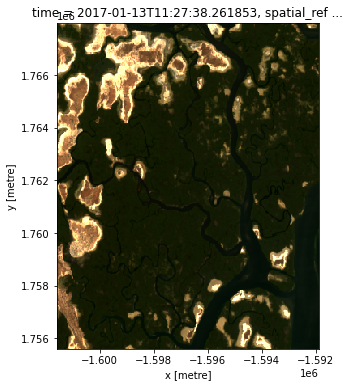

In [45]:
rgb(ds_c2_raw, index=0)

In [18]:
ds_c1.nir.max().values

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

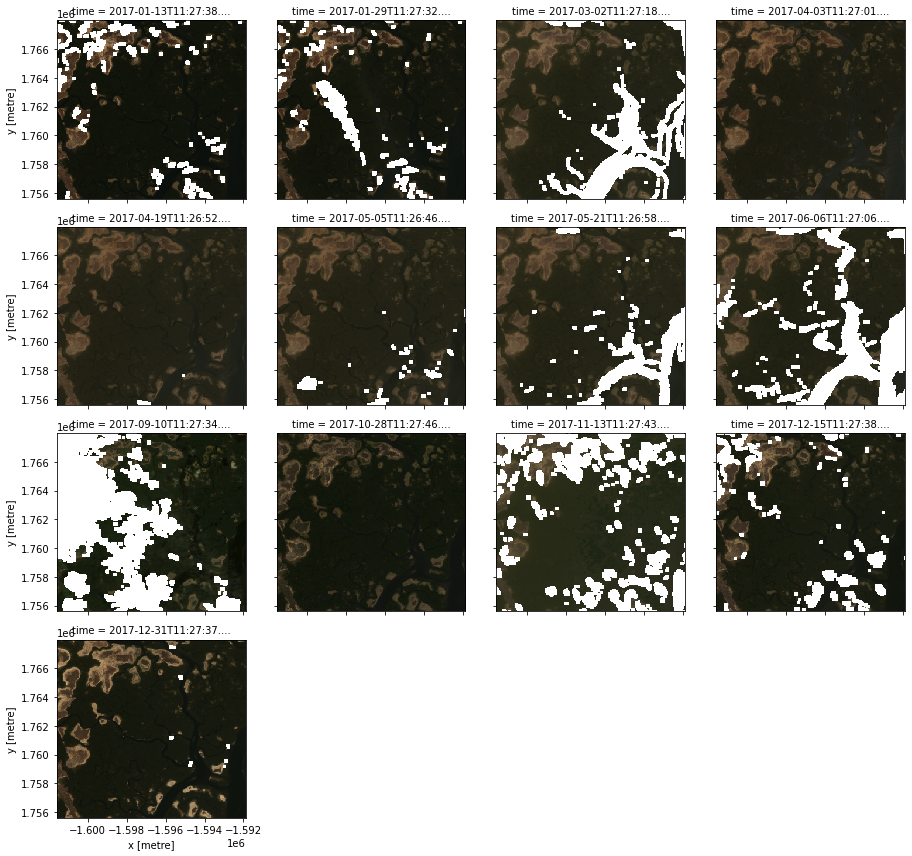

In [21]:
from odc.algo import to_rgba
to_rgba(ds_c1, (0, ds_c1.nir.max().values)).plot.imshow(col_wrap=4, col='time')

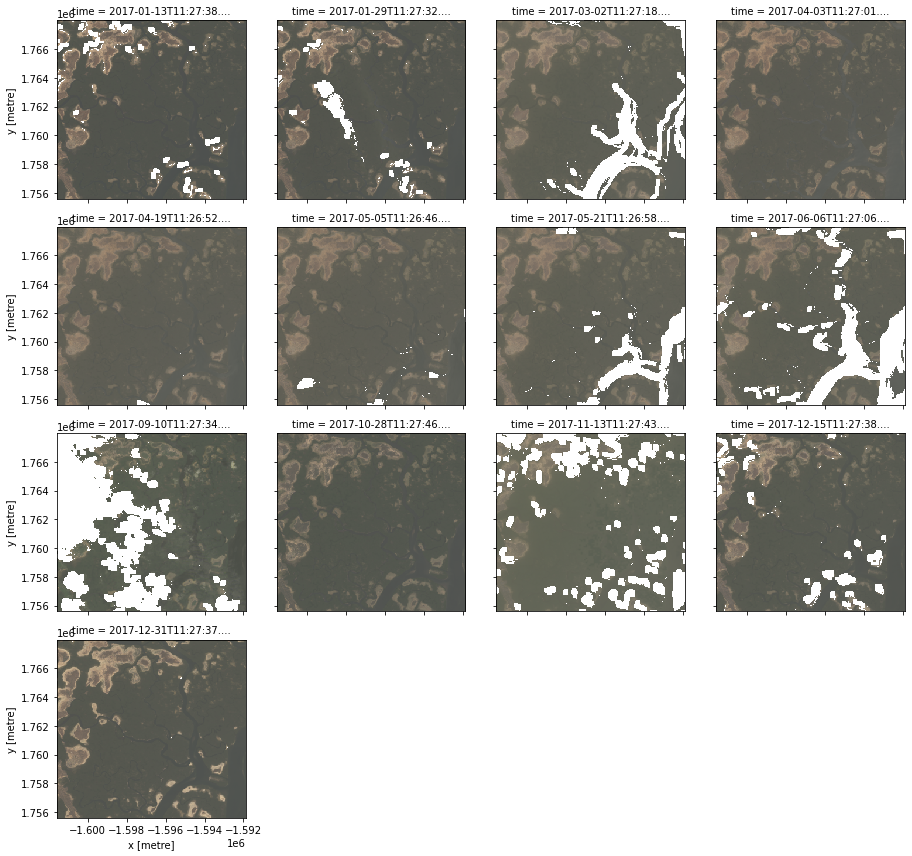

In [22]:
to_rgba(ds_c2, (0, ds_c2.nir.max().values)).plot.imshow(col_wrap=4, col='time')

In [ ]:
def xr_phenology(
    da,
    stats=[
        "SOS","POS","EOS","Trough","vSOS","vPOS",
        "vEOS","LOS","AOS","ROG","ROS",
    ],
    method_sos="first",
    method_eos="last",
    complete="fast_complete",
    smoothing=None,
):
    """
    Obtain land surface phenology metrics from an
    xarray.DataArray containing a timeseries of a 
    vegetation index like NDVI.
    last modified June 2020
    Parameters
    ----------

In [ ]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
# ds = (ds.nir - ds.red)/(ds.nir + ds.red)
ds = calculate_indices(ds, index=veg_proxy, collection='s2')
# ds1 = calculate_indices(ds1, index=veg_proxy, collection='s2')
# ds

In [ ]:
ts_stats = temporal_statistics(ds.NDVI,
                        stats=['discordance','f_mean', 'f_std',
                               'abs_change','complexity','central_diff'])

In [ ]:
stats=['discordance','f_mean', 'f_std', 'abs_change','complexity','central_diff']
x = temporal_statistics(ds.NDVI, stats=stats)
x

In [ ]:
fig, axes = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(16,6),
                       sharex=True,
                       sharey=True)

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')
    
# set colorbar size
cbar_size = 0.7
stats = ['discordance','f_mean_n1','f_mean_n2', 'f_mean_n3', 'f_std_n1',
         'f_std_n2', 'f_std_n3','abs_change','complexity','central_diff']
# set aspect ratios
for ax,stat_1,stat_2,stat_3,stat_4,stat_5 in zip(axes,stats[0:2], stats[2:4],stats[4:6],stats[6:8],stats[8:10]):
    x[stat_1].plot(ax=ax[0],cmap='viridis',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)
    ax[0].xaxis.set_visible(False)
    ax[0].yaxis.set_visible(False)
    
    x[stat_2].plot(ax=ax[1],cmap='magma',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)
    ax[1].xaxis.set_visible(False)
    ax[1].yaxis.set_visible(False)
    
    x[stat_3].plot(ax=ax[2],cmap='inferno',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[2].set_title(stat_3)
    ax[2].xaxis.set_visible(False)
    ax[2].yaxis.set_visible(False)
    
    x[stat_4].plot(ax=ax[3],cmap='cividis',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[3].set_title(stat_4)
    ax[3].xaxis.set_visible(False)
    ax[3].yaxis.set_visible(False)
    
    x[stat_5].plot(ax=ax[4],cmap='plasma',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[4].set_title(stat_5)
    ax[4].xaxis.set_visible(False)
    ax[4].yaxis.set_visible(False)

plt.tight_layout();


In [ ]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': ('2018-07', '2018-12'),
    'measurements': ['red', 'nir'],
    'resolution': (-10,10),
    'output_crs': 'epsg:6933'
}


# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              **query
              )

ds = calculate_indices(ds, index=veg_proxy, collection='s2')

In [ ]:
%%time
phen = xr_phenology(ds.NDVI,
                    method_sos='median',
                    method_eos='median',
                    complete='fast_complete',
                    smoothing='rolling_mean')
phen

In [ ]:
fig, axes = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(16,6),
                       sharex=True,
                       sharey=True)

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')
    
# set colorbar size
cbar_size = 0.7
stats=["SOS",
        "POS",
        "EOS",
        "LOS",
        "vSOS",
        "vPOS",
        "vEOS",
        "AOS",
        "ROG",
        "ROS",
    ]
# set aspect ratios
for ax,stat_1,stat_2,stat_3,stat_4,stat_5 in zip(axes,stats[0:2], stats[2:4],stats[4:6],stats[6:8],stats[8:10]):
    phen[stat_1].plot(ax=ax[0],cmap='magma_r',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)
    ax[0].xaxis.set_visible(False)
    ax[0].yaxis.set_visible(False)
    
    phen[stat_2].plot(ax=ax[1],cmap='magma_r',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)
    ax[1].xaxis.set_visible(False)
    ax[1].yaxis.set_visible(False)
    
    phen[stat_3].plot(ax=ax[2],cmap='YlGn',vmax=0.8,
               vmin=0,cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[2].set_title(stat_3)
    ax[2].xaxis.set_visible(False)
    ax[2].yaxis.set_visible(False)
    
    phen[stat_4].plot(ax=ax[3],cmap='YlGn',vmax=0.8,
               vmin=0,cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[3].set_title(stat_4)
    ax[3].xaxis.set_visible(False)
    ax[3].yaxis.set_visible(False)
    
    phen[stat_5].plot(ax=ax[4],cmap='coolwarm_r',vmin=-0.02,
              vmax=0.02,cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[4].set_title(stat_5)
    ax[4].xaxis.set_visible(False)
    ax[4].yaxis.set_visible(False)

plt.tight_layout();


In [ ]:
# ds.NDVI.time.dt.dayofyear.max()

In [ ]:
los = phen.EOS - Psos
z = ds.NDVI.time.dt.dayofyear.max() + (phen.EOS.where(phen.LOS < 0) - phen.SOS.where(phen.LOS < 0))

In [ ]:
z.plot()

In [ ]:
%%time
phen1 = xr_phenology(ds1.NDVI,
                    method_sos='median',
                    method_eos='median',
                    complete='fast_complete',
                    smoothing='wiener')
phen1

In [ ]:
z  = phen - phen1

In [ ]:
phen.SOS.plot()

In [ ]:
phen1.SOS.plot()

In [ ]:
z.SOS.plot()

In [ ]:
i_complete=fast_completion(i.NDVI)

In [ ]:
i_complete.mean(['x', 'y']).plot()

In [ ]:
x=smooth(i_complete)

In [ ]:
x.mean(['x', 'y']).plot()

In [ ]:
z = I_mapblocks - i_complete

In [ ]:
template=i.NDVI.drop('spatial_ref')

I_mapblocks = i.NDVI.map_blocks(
    fast_completion,
    template=template)

# I_mapblocks

In [ ]:
template=I_mapblocks

I_mapblocks_smooth = I_mapblocks.map_blocks(
    smooth,
    template=template).compute()

In [ ]:
I_mapblocks_smooth.mean(['x', 'y']).plot()

In [ ]:
j = I_mapblocks_smooth - x

In [ ]:
j.mean(['x', 'y']).plot()

In [ ]:
# def poly_fit(time, data, degree):
    
#     pfit = np.polyfit(time, data, degree) 
    
#     return np.transpose(np.polyval(pfit,time))

# def poly_fit_smooth(time, data, degree, n_pts):
#         """
#         """
    
#         time_smooth_inds = np.linspace(0, len(time), n_pts)
#         time_smooth = np.interp(time_smooth_inds, np.arange(len(time)), time)

#         data_smooth = np.array([np.array([coef * (x_val ** current_degree) for
#                                 coef, current_degree in zip(np.polyfit(time, data, degree),
#                                 range(degree, -1, -1))]).sum() for x_val in time_smooth])

#         return data_smooth

# def xr_polyfit(doy,
#                da,
#                degree,
#                interp_multiplier=1):    
    
#     # Fit polynomial curve to observed data points
#     if interp_multiplier==1:
#         print('Fitting polynomial curve to existing observations')
#         pfit = xr.apply_ufunc(
#             poly_fit,
#             doy,
#             da, 
#             kwargs={'degree':degree},
#             input_core_dims=[["time"], ["time"]], 
#             output_core_dims=[['time']],
#             vectorize=True,  
#             dask="parallelized",
#             output_dtypes=[da.dtype],
#         )
    
#     if interp_multiplier > 1:
#         print("Fitting polynomial curve to "+str(len(doy)*interp_multiplier)+
#                                                       " interpolated points")
#         pfit = xr.apply_ufunc(
#             poly_fit_smooth,  # The function
#             doy,# time
#             da,#.chunk({'time': -1}), #the data
#             kwargs={'degree':degree, 'n_pts':len(doy)*interp_multiplier},
#             input_core_dims=[["time"], ["time"]], 
#             output_core_dims=[['new_time']], 
#             output_sizes = ({'new_time':len(doy)*interp_multiplier}),
#             exclude_dims=set(("time",)),
#             vectorize=True, 
#             dask="parallelized",
#             output_dtypes=[da.dtype],
#         ).rename({'new_time':'time'})
    
#         # Map 'dayofyear' onto interpolated time dim
#         time_smooth_inds = np.linspace(0, len(doy), len(doy)*interp_multiplier)
#         new_datetimes = np.interp(time_smooth_inds, np.arange(len(doy)), doy)
#         pfit = pfit.assign_coords({'time':new_datetimes})
    
#     return pfit

# # da=xr_polyfit(dayofyear=dayofyear, 
# #               da=da,
# #               degree=degree,
# #               interp_multiplier=interp_multiplier)

In [ ]:
# #set up figure
# fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(18,25), sharex=True, sharey=True)

# #start of season
# temp_stats.discordance.plot(ax=ax[0,0])
# ax[0,0].set_title('discordance')
# temp_stats.f_std.plot(ax=ax[0,1])
# ax[0,1].set_title('f_std')

# #peak of season
# temp_stats.f_mean.plot(ax=ax[1,0])
# ax[1,0].set_title('f_mean')
# phen.f_median.plot(ax=ax[1,1])
# ax[1,1].set_title('f_median')

# #end of season
# temp_stats.mean_change.plot(ax=ax[2,0])
# ax[2,0].set_title('mean_change')
# phen.med_change.plot(ax=ax[2,1])
# ax[2,1].set_title('med_change')

# #Length of Season
# temp_stats.abs_change.plot(ax=ax[3,0])
# ax[3,0].set_title('abs_change');

# #Amplitude
# temp_stats.complexity.plot(ax=ax[3,1])
# ax[3,1].set_title('complexity')

# #rate of growth
# temp_stats.central_diff.plot(ax=ax[4,0])
# ax[4,0].set_title('central_diff')

# #rate of Sensescence
# temp_stats.num_peaks.plot(ax=ax[4,1])
# ax[4,1].set_title('num_peaks');

# plt.tight_layout();